In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from langchain.agents import initialize_agent, load_tools
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_core.prompts import PromptTemplate
import pandas as pd
from datasets import load_dataset
from openai import OpenAI
from rouge import Rouge
from rouge_score import rouge_scorer
from pprint import pprint
import nltk
import evaluate
import tiktoken
from transformers import pipeline
import matplotlib.pyplot as plt


/opt/anaconda3/envs/LLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-05 19:01:03.913199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load environment variables.
load_dotenv()

# Set the model name for our LLMs that can be easily swapped for a different model.
OPENAI_MODEL = "gpt-4-turbo"

# Store the API key in a variable.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [2]:
# Transforming the transcript from my meeting into so it can be read by OpenAI via the API
transcript = pd.read_json('../Resources/vertopal.com_Discuss Collaborative Testing prior to release.json', orient='index')
# Remove the hash '#' below to review the transcript in JSON
#transcript

In [3]:
# Getting the number of tokens that we need to understand if we're going beyond the available pull parameters of OpenAI
transcribed_mtg = str(transcript[0])
print(len(transcribed_mtg))

56998


**Note:** Code below was collaborated on with Nik Psyllas to split the token len to get OpenAI to be able to read it. 
All bot prompts were engineered based on my condensed learnings from Google's AI Prompt Engineering Course (https://www.youtube.com/watch?v=p09yRj47kNM&t=184s&ab_channel=TinaHuang)

In [4]:
# Splitting transcription if max token limit is possibly exceeded
max_len = 37000

if len(transcribed_mtg) >= max_len:

    transcribed_mtg_trimmed_list = [transcribed_mtg[i:i + max_len] for i in range(0, len(transcribed_mtg), max_len)]



# Chat Bot that will Query the uploaded transcripts and answer questions


In [56]:
# Initializer the pipeline to generate questions and answers using the distilbert-base-case-distilled-squad model we learned in class
question_answerer = pipeline('question-answering', model='distilbert-base-cased-distilled-squad')

# Source is our transcript
text = transcribed_mtg

# Generating a list of questions that we can create  an input for, just using known question
questions = ["How many waves did we agree to releasing software in?",
             "When should a release candidate be made available to solution center for testing?",
             "Where should the PM open the ticket for securing resources prior to the release?"]

Device set to use mps:0


In [39]:
# Checking the questions outputs
question = "on what date should a release candidate be made available for testing prior to the 1st wave of release?"

# Pass the question and test the answer
result = question_answerer(question=question, context=text)
result

{'score': 0.616129457950592, 'start': 13517, 'end': 13524, 'answer': 'a month'}

In [54]:
# Import Pandas 
import pandas as pd

# Create a function to generate the answers based on an input text.
def question_answer(questions, text):
    # Create a list to hold the data that will be added to the DataFrame.
    data = []
    # Use a for loop to iterate through the questions.
    for question in questions:
        # Pass the question and text to the initialized question_answerer. 
        result = question_answerer(question=question, context=text)
        # Retrieve the question, answer, the score, the starting 
        # and ending of where the answer is located in the text.
        data.append([question, result['answer'], result['score'], result['start'], result['end']])
    # Create a DataFrame from the data with appropriate columns. 
    df = pd.DataFrame(data, columns=["Question", "Answer", "Score", "Starting Position", "Ending Position"])
    # Return the DataFrame
    return df

In [57]:
# Call the question_answer function with the questions and text.
question_answer(questions, text)

,Question,Answer,Score,Starting Position,Ending Position
0,How many waves did we agree to releasing softw...,three,0.632711,6068,6073
1,When should a release candidate be made availa...,two months prior to a release date,0.712697,30663,30697
2,Where should the PM open the ticket for securi...,VPP,0.930608,24583,24586


# Summarizer Bot that will summarize uploaded transcripts with key takeaway and learning

In [10]:
# Create a Summarizer
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name=OPENAI_MODEL, temperature=0)

# Prompt for the Summarizer
sum_prompt_template = """You are a intelligent and detailed-oriented meeting assistant. Your task is to provide a comprehensive summary from the provided transcription.

Your output should be structured as follows:

**1. Meeting Summary:**

* Provide a detailed narrative summary of the meeting, capturing the key topics discussed, decisions made, and any important points raised. Aim for a length of approximately 200-300 words.

**2. Key Learnings:**

* Extract and present the most important takeaways and insights from the meeting in a bullet-point list. Each bullet point should be concise and clearly articulate a key learning.

Transcript:
{text}
"""
# Using a prompt template to define the prompt
sum_prompt = PromptTemplate(template=sum_prompt_template, input_variables=["text"])

# Instantiate the summarizer chain using simpler chain_type = 'stuff'
chain = load_summarize_chain(llm, chain_type="stuff", prompt=sum_prompt, document_variable_name='text')

# Create document objects from the filtered transcripts
docs = [Document(page_content=doc) for doc in transcribed_mtg_trimmed_list]

# Batching the docs
def batch_documents(docs, batch_size=1):
    for i in range(0, len(docs), batch_size):
        yield docs[i:i + batch_size]

batch_summaries = []
for batch in batch_documents(docs):
    combined_text = '\n\n'.join([doc.page_content for doc in batch])
    summary = chain.run(input_documents=batch)
    batch_summaries.append(summary)

# summarize all summaries
final_input_docs = [Document(page_content=summary) for summary in batch_summaries]
final_summary = chain.run(input_documents=final_input_docs)

print(final_summary)


/var/folders/n0/pbfvzgnj0db4mnvdjytkzzc00000gn/T/ipykernel_40232/190809785.py:37: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = chain.run(input_documents=batch)


**1. Meeting Summary:**

The meeting convened to address the challenges and strategize improvements in the release process for customer-specific product implementations. Zain Master initiated the discussion by highlighting the recurring issues with product releases that have led to customer dissatisfaction and internal stress due to compatibility issues between the core product functionalities and customer-specific implementations. The goal was to enhance internal confidence and external acceptance of product releases.

Zain proposed a cross-collaborative approach between the solution center and the core product teams to enhance testing protocols. He shared insights from his discussions with Peter Lafferman, focusing on identifying gaps in the current testing process and proposing action items to bridge these gaps.

Lukas Kawulok raised concerns about the previous release failures and questioned the continuation of phased releases and increased testing participation from the solution c

## Summarizer Evaluation
Two methods we'll be using are ROUGE & BLEU.
Using Rouge (Recall oriented understudy for Gisting Evaluations) to measure how good the summarization quality.
Rouge is calculated using different n-grams (a text analysis technique used to identify patterns and relationships in text data - frequency and distribution of words within sentence structures); 'Rouge-L' measures the similarity between the word sequence of the generated abstract and the reference abstract using the longest sequence of words in common (string matching approach); 'Rouge-Lsum is a variation of Rouge-L that divides the generated summary and reference summary inot sentence using tand measures the similarity between them. Basically, in short all of these metrics measure the overlap between the word strings of the generated summary and the reference summary. 

In [11]:
# Generated summaries: Human (me), OpenAI, and Anthropic models below. 
# (Could put this away as a utils but wanted the evaluator to see it for reference)

# Meeting was summarized by me, to server as a human comparision
reference_Human= """Core Product Team (Engineering and Product Management) met with members from the Solution Center, responsible for developing and managing customizations 
on customer's CPQ implementations to improve confidence in GA releases and customer adoption of the release. The focus of this meeting was to outline collaboration between 
Core Product and Solution Center to test the release candidate code prior to making it generally available for release. A process was defined on how Core Product teams can 
book and secure resources well in advance of the release from Solution Center to ensure testing of the code in customer environments. Core Product also agreed to demo'ing features in 
the release with members of the Solution Center to keep them in the loop. Product has also requested Solution Center engineers to save the output of outbound APIs before they hit customer intergrations/
applications to help with troubleshooting escalated issues. Multiple other topic discussions yet to be discussed (API performance testing, customer application security access, and test automation)
were to be discussed in a follow-up meeting to be scheduled by product management.
Key Topic Takeaways:
Wave Releases:
- Team is going to keep with the Wave Release Schedule for August
- Assistance needed from DevOps to ensure that ALL lower environments are being migrated in addition to Production for the customer Test/Dev/Stage
- Need to have 3 App Gateways, one per wave to make DevOps easier
- Lukas/ Terry to follow up with Chintan

Solution Center Participation/ Testing:
- CPQ PM to open JIRA ticket in PMOR Project 2 months prior to release to secure and schedule SC resources for testing
- Ticket should include scope of work completed within upcoming release
- Petr K to provide a summary of process/ details for the ticket

Once ticket is created, Petr K will:
- Identify list of customers for testing most impacted by scope of work
- SC Team members will be selected based on customers implementation complexity and understanding

Escalation path for SC is still going to be through Support to isolate Eng from configuration / data / customization issues
- Program Management to schedule weekly touchpoints for SC, Eng, Prod, Support to meet
- Internal page in confluence will be created to track SC testing progress on customers identified by Petr K
- Eng to provide updates on testing and any regressions encountered / updates to SC requests post Support triage

Communications:
This is being worked on a different channel with Stephen Pack and Lauren to ensure comms are scheduled appropriately, there is an owner, and lastly internal and external customer clearly know the schedule of release

Task for Next Meeting:
- Core Team API Testing & Performance Baseline Compare
- Solution Center Team to save outputs prior to customer integration points for release-to-release compare (Assist with root cause – core, customization, customer end)
- Core Team to incorporate SC Typescript Automated tests within our Regression Testing
- Core / Support Team access to customer side integrations (Salesforce, SAP, etc)
- Graylog monitoring"""


# Meeting was summarized by Anthropic/ Claude to compare LLMs to LLMs
reference_anthropic =""" Meeting Purpose: The meeting on April 29, 2025, focused on improving confidence in product releases by addressing issues with customer-specific implementations. The discussion centered on preventing the cycle of problems that occur when releases are incompatible with customer implementations, which results in multiple fixes and customer dissatisfaction.
Key Discussion Points
1. Release Wave Approach

The team discussed continuing with a wave-based release approach, where releases go to different customer segments at different times
Benefits: Protects high-value customers (20 percent of customers generating 80 percent of revenue) from initial issues
Challenges: Complex communication, infrastructure requirements, and coordination issues
Current plan: Implement for major releases (August, December), but not for patches

2. Testing Resource Allocation

Solution Center QA resources must be booked 1.5+ months in advance for release testing
Process needs formalization: CPQ team will create tickets in JIRA (PMOR project) to request resources
Peter will document the detailed process for resource booking
QA testing should focus on both general regression testing and tests for specific new features
Team needs to select a set of complex customer implementations for consistent testing

3. Communication and Coordination

Need for better coordination between Product and Solution Center teams
A chat channel (smaller than the previous "war room") for distinguishing core vs. customization issues
Discussed involving Support in the pre-release evaluation to protect engineering resources

4. Demo and Information Sharing

Team agreed that Sprint-level demos would be excessive
Plan to leverage existing Pulse 2 demo (in June) and potentially add a demo to the Release to Ops process
Need to ensure demo information reaches Solution Architects and Center teams

5. Integration Testing

Discussion about generating and storing integration outputs to compare before/after releases
Challenges with connector access after project completion (often disappear)
Need for improved management of connector access with standardized Vendavo accounts
CPQ team needs to add API performance testing to their test scope

Action Items

Peter will document the process for booking QA resources via JIRA
Zain/Stephen to work on communication plans for release waves
Cloud OPS and engineering to investigate infrastructure requirements for wave releases
Consider adding a demo to Release to Ops meeting
Plan API performance testing in the roadmap
Follow up with Peter Loffelmann regarding proof of concept for integration output comparison

The meeting concluded with agreement to schedule a follow-up to cover remaining topics. """

In [28]:
# ROUGE: 
# Lets evaluate the summarize using ROUGE (Recall-oriented understudy for Gisting Evaluations), which compares the output from the LLM against Human written summaries 
# ROUGE scores (ROUGE-1,ROUGE-2, ROUGE-L) provide a quantitative measure of the summary's quality.
# ROUGE emphasizes recall (how much of the reference text is captured in the generated text), making it better for summarization 
# where capturing all key points is more important than exact wording

def evaluate_summary_rouge(generated_summary, reference_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    scores= scorer.score(generated_summary, reference_summary)
    return {'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_f1': scores['rougeL'].fmeasure,
    }
            

scores_1 = evaluate_summary_rouge(final_summary, reference_Human)
scores_2 = evaluate_summary_rouge(final_summary, reference_anthropic)

print(f'Generated(OpenAI) vs. Written (Human): {scores_1}')
print(f'Generated(OpenAI) vs. Generated (Anthropic): {scores_2}')

Generated(OpenAI) vs. Written (Human): {'rouge1_f1': 0.4480746791131855, 'rouge2_f1': 0.08888888888888888, 'rougeL_f1': 0.1703617269544924}
Generated(OpenAI) vs. Generated (Anthropic): {'rouge1_f1': 0.485006518904824, 'rouge2_f1': 0.10718954248366014, 'rougeL_f1': 0.19295958279009126}


In [21]:
# BLEU:
# Lets try to use another evaluation method called Bleu to evaluate
# BLEU primarily measures precision (how much the generated text overlaps with a reference text), making it more suitable for 
# machine translation tasks where fluency and fidelity to the reference are crucial

BLEUscore_SumActionvsHuman = nltk.translate.bleu_score.sentence_bleu([reference_Human], final_summary, weights = (0.5, 0.5))
print(f'Generated(OpenAI) vs. Written (Human) BLEU Score = {BLEUscore_SumActionvsHuman}')

BLEUscore_SumActionvsAnthropic = nltk.translate.bleu_score.sentence_bleu([reference_anthropic], final_summary, weights = (0.5, 0.5))
print(f'Generated(OpenAI) vs. Generated (Anthropic) BLEU Score = {BLEUscore_SumActionvsAnthropic}')

Generated(OpenAI) vs. Written (Human) BLEU Score = 0.7024872780392023
Generated(OpenAI) vs. Generated (Anthropic) BLEU Score = 0.8073800226630741


**Analysis**
Overall Comparison: The scores indicate that the "Generated (OpenAI)" summary has a higher degree of similarity with the "Generated (Anthropic)" summary than with the "Written (Human)" summary, across both ROUGE and BLEU metrics.

ROUGE-1: The ROUGE-1 scores show a moderate amount of single-word overlap. The OpenAI summary shares more words with the Anthropic summary (0.485) than with the Human summary (0.448).

ROUGE-2: The ROUGE-2 scores are quite low, indicating that the summaries share relatively few word pairs. Again, OpenAI has a slightly higher bigram overlap with Anthropic (0.107) compared to Human (0.089). Low ROUGE-2 scores are common, especially for abstractive summarization, where the generated summaries may use different wording than the references.

ROUGE-L: The ROUGE-L scores, which consider sentence structure, are between ROUGE-1 and ROUGE-2, showing some similarity in the overall sequence of words. OpenAI has a higher ROUGE-L score when compared to Anthropic (0.193) than when compared to Human (0.170).

BLEU: The BLEU scores also support the trend seen in the ROUGE scores.  The OpenAI summary has a higher BLEU score when compared to the Anthropic summary (0.807) than when compared to the Human summary (0.702).  BLEU emphasizes n-gram precision, and these scores suggest that OpenAI's summary has a higher precision of word sequences when compared to Anthropic.

*What the Scores Suggest:*
- The OpenAI and Anthropic summaries are more similar to each other in terms of word choice and sentence structure than either is to the human-written summary. This could imply that both AI models exhibit similar summarization tendencies or biases.
- The relatively low ROUGE-2 scores suggest that the summaries, while capturing some of the same information (as indicated by ROUGE-1 and ROUGE-L), use different phrasing and sentence structures.
- The BLEU scores indicate that OpenAI's summary has a higher precision of n-grams when compared to Anthropic, further highlighting the similarity between the two AI-generated summaries.


**NOTE:** 
With Rouge specifically, either I suck at writing meeting notes or the model sucks at evaluation. For when I read the generate summary  of the meeting, I am fairly certain that its capturing all of the main points. 

In [58]:
# TOKEN COMPARISION & COMPRESSION: 
# Using Token counts as a way to measure the summarizers effectiveness

encoding_name = "cl100k_base"
encoding = tiktoken.get_encoding(encoding_name)

# Count tokens
token_count_Meeting = len(encoding.encode(transcribed_mtg))
token_count_final_summary = len(encoding.encode(final_summary))
token_count_human_summary = len(encoding.encode(reference_Human))
token_count_anthropic_summary = len(encoding.encode(reference_anthropic))



# Printing the specific Token Counts and Compression in comparision to original for each type of summary
print(f'Token count for the FULL transcript {token_count_Meeting}')
print(f'Token count for Human Reference Summary: {token_count_human_summary} & Compression ratio is: {token_count_Meeting / token_count_human_summary}')
print(f'Token count for SumAction Generated Summary: {token_count_final_summary} & Compression ratio is: {token_count_Meeting / token_count_final_summary} ')
print(f'Token count for Anthropic Generated Summary: {token_count_anthropic_summary} & Compression ratio is: {token_count_Meeting / token_count_final_summary}')
print(tokens)

Token count for the FULL transcript 14378
Token count for Human Reference Summary: 598 & Compression ratio is: 24.043478260869566
Token count for SumAction Generated Summary: 449 & Compression ratio is: 32.02227171492205 
Token count for Anthropic Generated Summary: 486 & Compression ratio is: 29.584362139917694
[14378, 449, 598, 486]


In [59]:
#Plot tokens and compressions
tokens = [token_count_Meeting, token_count_final_summary, token_count_human_summary, token_count_anthropic_summary]
compressions = [token_count_Meeting / token_count_human_summary,token_count_Meeting / token_count_final_summary, token_count_Meeting / token_count_final_summary ]


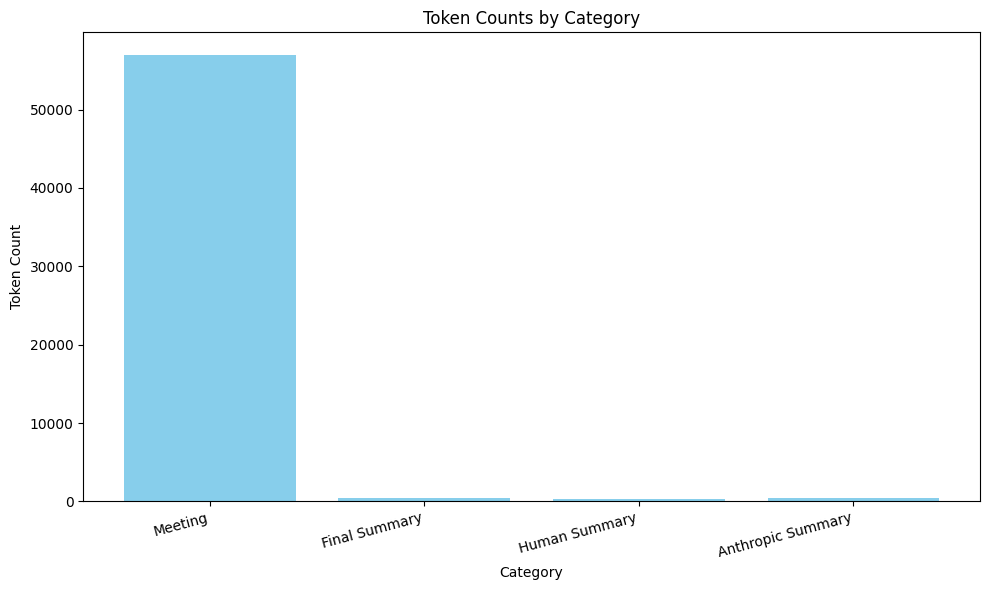

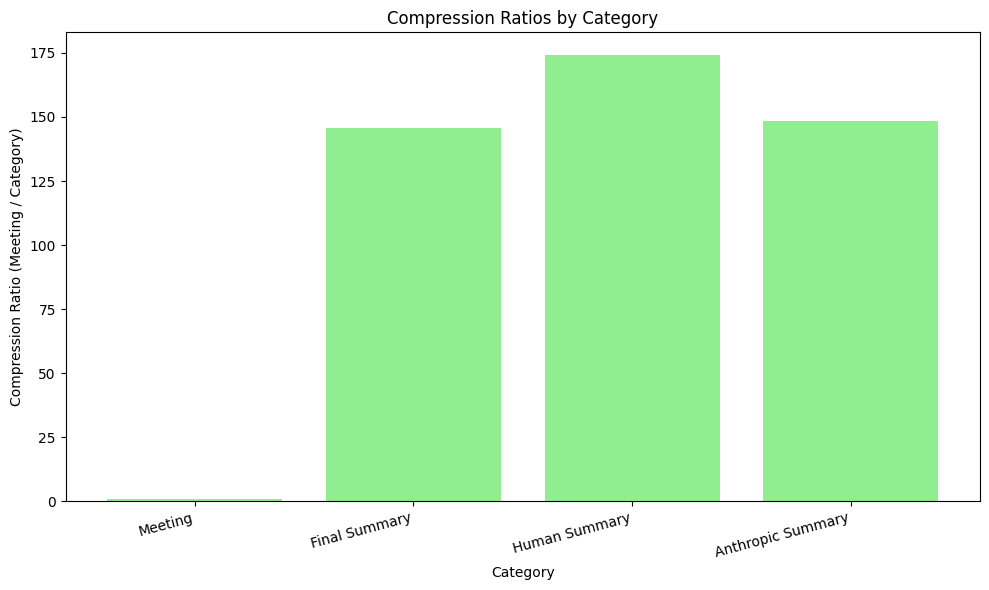

In [69]:
# Plotting the tokens
data = {
    'Category': ['Meeting', 'Final Summary', 'Human Summary', 'Anthropic Summary'],
    'Token Count': [56998, 391, 327, 384],
    'Compression Ratio': [1, 145.78, 174.3, 148.43]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the first bar graph: Token Counts using pandas and matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df['Category'], df['Token Count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Token Count')
plt.title('Token Counts by Category')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Create the second bar graph: Compression Ratios using pandas and matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df['Category'], df['Compression Ratio'], color='lightgreen')
plt.xlabel('Category')
plt.ylabel('Compression Ratio (Meeting / Category)')
plt.title('Compression Ratios by Category')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Action Items Bot that will sift through the provided transcript and extract key action items for organizer to review

In [47]:
# Prompt the bot to identify action items from the meeting transcript and try to
prompt2 = """You are an intelligent assistant tasked with extracting all unique calls to action from the following text. Return each call to action seperately with a newline character. For example:

-Call to Action 1
-Call to Action 2
-Call to Action 3
...

Here is the text:
"""
client = OpenAI()

# Instantiate chain
chain3 = client.chat.completions.create(model=OPENAI_MODEL, messages=[{'role': 'system', 'content': prompt2},
                                                                      {'role': 'user', 'content': transcribed_mtg}]
                                                                      )

calls = chain3.choices[0].message.content
print(calls)

-Propose and come up with ways on how to avoid repetitive release issues.
-Come up with new ideas to improve internal confidence and external acceptance of the release.
-Identify one individual from the solution center organization to intake information and share it within the organization.
-Establish a regular and systematic way of booking resources well in advance for testing.
-Formalize the process of reaching out and communicating the need for resources.
-Generate and store output for integrations prior to every release to compare.
-Consider adding API performance testing as part of the scope of the test.


In [44]:
# Create a dataframe for Bot to reference and assign task duration / weight to each action item
capacity = pd.read_csv('/Users/zainmaster/Desktop/Homeworks/Project_3_LLMs/Meeting-Bot/Resources/CommonTasks.csv')
capacity.head()

,Common Tasks Types,Average Task duration in minutes,Tasks weights
0,Send Email,10,0.25
1,Create Power point on known topic,120,2.00
2,Create Power point on new unfamiliar topic,240,3.00
3,Schedule Meeting,10,0.25
4,Work on small project,1200,5.00


In [45]:
# Converting the common tasks to list so that the bot can read it
capacity1 = capacity[['Common Tasks Types', 'Average Task duration in minutes']]
list_capacity = capacity1.values.tolist()
list_capacity

[['Send Email ', 10],
 ['Create Power point on known topic', 120],
 ['Create Power point on new unfamiliar topic', 240],
 ['Schedule Meeting', 10],
 ['Work on small project ', 1200],
 ['Work on medium project', 1600],
 ['Work on large project', 2400],
 ['Define process from scratch ', 1600],
 ['Refine a existing process', 1200],
 ['Review candidates for new role', 1600],
 ['Schedule interviews with new candidates', 30],
 ['Manage Budgets', 2400],
 ['Prioritizing work', 60],
 ['Training others on job', 90],
 ['Creating Marketing Campaign development', 120],
 ['Setting up and deploying marketing campaigns', 60],
 ['Planning Event', 120],
 ['Following up on tasks such as emails and progress with team', 120],
 ['Creating Reports', 180],
 ['Writing techinical documents', 60],
 ['Writing creative documents such as marketing or product requirements', 180],
 ['Problem solving or learning concepts to identify solutions', 180],
 ['Setup API to store oputput', 60],
 ['Provide Demo ', 60],
 ['API 

In [48]:
# Bot to assign a value (hours / weights) to the action items identified from the meeting transcription
prompt3 = """You are a smart and intelligent project manager that understand how much time it could take on average to complete a action item. 
Based on all of the action items / calls from the uploaded meeting transcript, you will reference a table of common tasks and assign to each task a approximate time value in minutes.
If a task is hard for you to assign a time to complete, list the task followed by 'Unable to estimate'
For every task to do, list the task followed by the duration on the same continuous line.
Your output should be a list of every task from the list, and their average time to complete.
Ensure each task entry and their duration to complete are one continuous line.
An Example Output List:

Task 1: (# Mins)
Task 2: (# Mins)
Task 3: (# Mins)
Task X: (Unable to estimate).
"""

client = OpenAI()
# Instantiate chain
chain3 = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[{'role': 'system', 'content': prompt3},
              {'role': 'user', 'content': f"Tasks: {str(calls)}\n Duration: {str(list_capacity)}\n"}]
)

calls_list = chain3.choices[0].message.content
calls_list = calls_list.strip('\n \n')
print(calls_list)

Propose and come up with ways on how to avoid repetitive release issues: (Work on large project) 2400 mins
Come up with new ideas to improve internal confidence and external acceptance of the release: (Work on large project) 2400 mins
Identify one individual from the solution center organization to intake information and share it within the organization: (Review candidates for new role) 1600 mins
Establish a regular and systematic way of booking resources well in advance for testing: (Define process from scratch) 1600 mins
Formalize the process of reaching out and communicating the need for resources: (Refine a existing process) 1200 mins
Generate and store output for integrations prior to every release to compare: (Setup API to store output) 60 mins
Consider adding API performance testing as part of the scope of the test: (API performance testing) 2400 mins


In [50]:
# Adding it all together, meeting summary and action items from the bots above
meeting_results = {'summary': final_summary, 'action items': calls_list}

meeting_results['summary'] = 'Summary:\n\n' + meeting_results['summary'] + '\n'
meeting_results['action items'] = ('Action Items:\n' + meeting_results['action items']).replace('\n', '\n\n')

print(meeting_results['summary'])
print(meeting_results['action items'])

Summary:

**1. Meeting Summary:**

The meeting convened to address the challenges and strategize improvements in the release process for customer-specific software implementations. Zain Master initiated the discussion by highlighting the recurring issues of compatibility between product core functionality and customer-specific implementations, which have led to multiple release failures and customer dissatisfaction. The goal was to enhance internal confidence and external acceptance of releases.

The conversation focused on the need for enhanced testing that aligns with specific customer environments, proposing a cross-collaborative approach between the solution center and core product teams. Zain shared insights from his research and discussions with Peter Lafferman, emphasizing the gaps in current testing practices.

Lukas Kawulok raised concerns about the previous release strategies, particularly the decision to roll out releases in waves, which although helped in managing risks, al